## Project : Advance Lane Finding

### Udacity Self Driving Car Engineering Nanodegree - Project 2

The goal of this project is to develope a image and video processing pipeline that would be able to, 

    1. Find Calibration parameters of the camera and remove distortion from the camera stream.
    2. Locate the lane lines (Curved and Straight).a
    3. Find the car offset from the center of the lane.
    4. Find the radius of curvature of the road.


In [66]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
import os
import pickle as pk
import glob 
import moviepy.editor as mov

%matplotlib inline

### Step 1: Camera Calibration and distortion correction

Finding the camera calibration matrix and distortion coefficients using a series of chessboard images, and using the computed parameters to remove the distortion from the images and the camera feed.


In [51]:
def compute_calibration_parameters():
        
    # Getting all the images from the given directory using glob library
    images = glob.glob("./camera_cal/*.jpg")
    
    # Preparing the array for ObjectPoints and the corresponding pixel location (ImagePoints) array
    # Object Points is the matrix like numbering of the points (we know the count) which we want 
    ObjPoints = np.zeros((9*6,3), np.float32)
    ObjPoints[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Empty array of the ImgPoints and ObjPoints
    ObjP = []
    ImgP = []

    # Setting the termination criteria for the cornerSubPix method
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # Accessing all the images using glob module
    for i, image in enumerate(images):
        input_image = mpimg.imread(image)

        gray_image = cv.cvtColor(input_image, cv.COLOR_BGR2GRAY)

        ret, corners = cv.findChessboardCorners(gray_image, (9,6), None)
        #print(ret)
        if(ret == True):
            ObjP.append(ObjPoints)
            #Finding more Accurate Corner points in image
            corners_accurate = cv.cornerSubPix(gray_image, corners, (11,11), (-1,-1), criteria)

            #print(dir(corners_accurate))
            # Appending the image points to the ImgP
            ImgP.append(corners_accurate)

            #Drawing the corners and Displaying them
            cv.drawChessboardCorners(input_image, (9,6), corners_accurate, ret)

            # Calibrating the camera using the Image Points and Object Points
            ret, cam_mtx, dist, rvec, tvec = cv.calibrateCamera(ObjP, ImgP, input_image.shape[:-1], None, None)

            # Getting Refined Camera Matrix
            h,w = input_image.shape[:-1]
            newCamMtx, roi = cv.getOptimalNewCameraMatrix(cam_mtx,dist, (w,h), 1, (w,h))


            # Undistroting the image
            undist = cv.undistort(input_image, cam_mtx, dist, newCamMtx)

            fig1, ax1 = plt.subplots(1, 2, figsize=(8,4) , constrained_layout=True)
            ax1[0].imshow(input_image)
            ax1[0].set_title("Input Image")
            ax1[1].imshow(undist)
            ax1[1].set_title("Undistorted Image")

            data = [ret, cam_mtx ,newCamMtx, dist, rvec, tvec]
    print("Camera Calibration Done.")

    return data


def undistrot(input_image, data):
    
    ret, mtx, newCamMtx, dist, rvec, tvec = data
    # Undistorting the image
    input_image = cv.undistort(input_image, mtx, dist, newCamMtx)  
    return input_image
        

Camera Calibration Done.


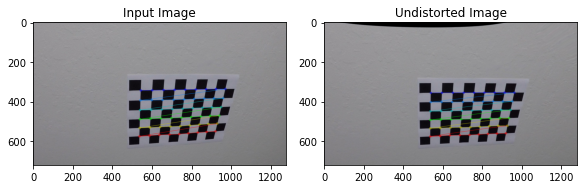

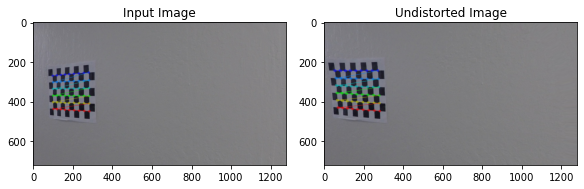

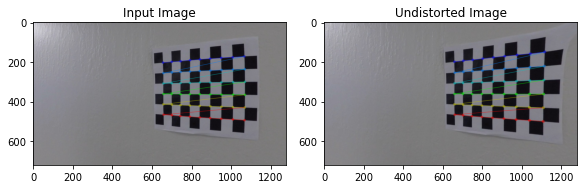

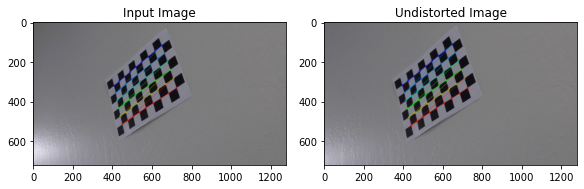

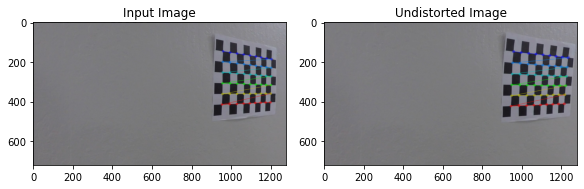

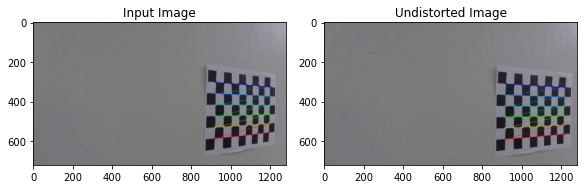

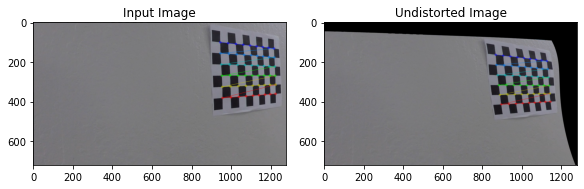

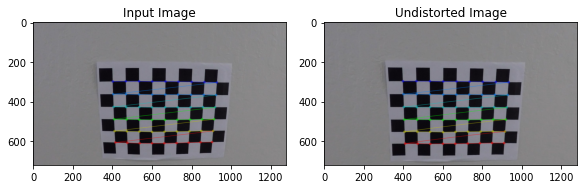

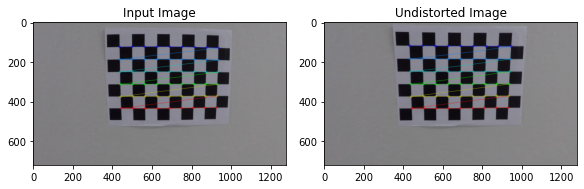

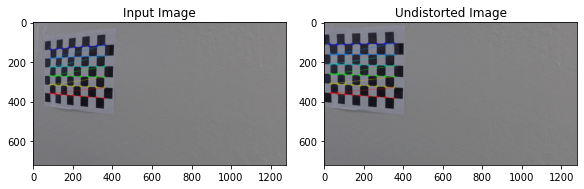

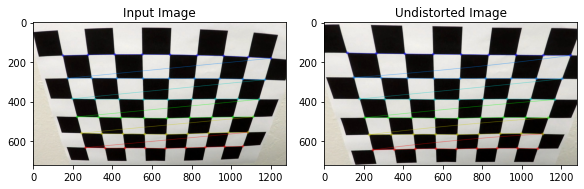

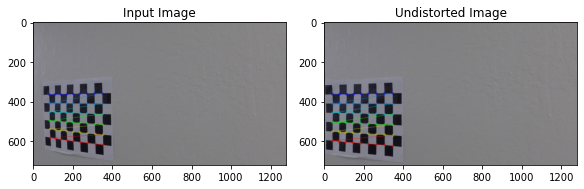

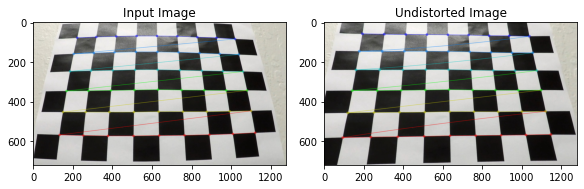

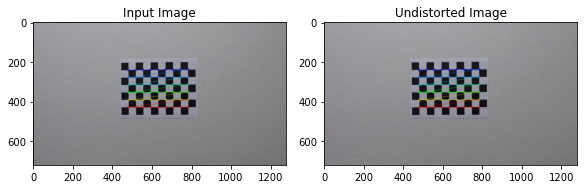

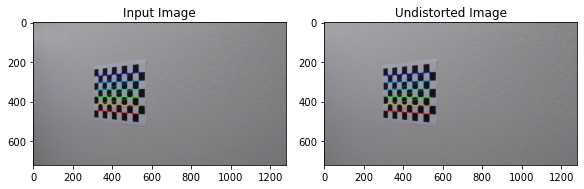

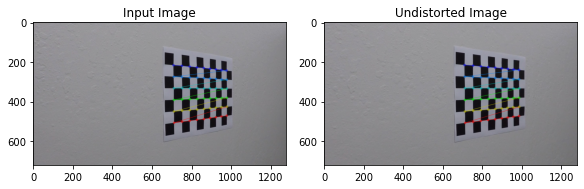

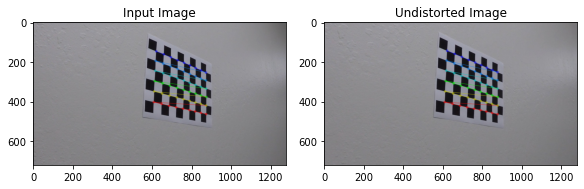

In [52]:
cal_data = compute_calibration_parameters()

In [ ]:
def readImages(dir_name):
    print("Loading Images from " + dir_name + " directory")
    images = glob.glob(dir_name+"/*.jpg")
    return images

In [53]:

''' 
    Combining different threshold for better detection of the lanes (Sobel - magnitude, direction and   )
'''
def sobel_thres(in_img, orientation='xy', lowerThreshold = 50, upperThreshold = 240):

    gray_img = cv.cvtColor(in_img, cv.COLOR_RGB2GRAY)


    # Reducing the Noise by applying the Gaussian Blur
    gray_img = cv.GaussianBlur(gray_img, (5,5) , 1.3)

    # Detecting Edges (Canny Detector)
    # edges = cv.Canny(in_img[:,:,2], lowerThreshold, upperThreshold)

    edges_binary = np.zeros_like(gray_img)

    if (orientation == 'x'):
        edgeX = cv.Sobel(gray_img, cv.CV_64F, 1, 0, ksize=3)
        abs_edgeX = np.absolute(edgeX)
        scaled_edgeX = (abs_edgeX/np.max(abs_edgeX))*255
        edges_binary[(scaled_edgeX >= lowerThreshold) & (scaled_edgeX <= upperThreshold)] = 1    

    if (orientation == 'y'):
        edgeY = cv.Sobel(gray_img, cv.CV_64F, 0, 1, ksize=3)
        abs_edgeY = np.absolute(edgeY)
        scaled_edgeY = (abs_edgeY/np.max(abs_edgeY))*255
        edges_binary[(scaled_edgeY >= lowerThreshold) & (scaled_edgeY <= upperThreshold)] = 1

    if (orientation == 'xy'):

        edgeX = cv.Sobel(gray_img, cv.CV_64F, 1, 0, ksize=3)
        abs_edgeX = np.absolute(edgeX)
        scaled_edgeX = (abs_edgeX/np.max(abs_edgeX))*255

        edgeY = cv.Sobel(gray_img, cv.CV_64F, 0, 1, ksize=3)
        abs_edgeY = np.absolute(edgeY)
        scaled_edgeY = (abs_edgeY/np.max(abs_edgeY))*255


        edges_binary[(scaled_edgeX >= lowerThreshold) & (scaled_edgeX <= upperThreshold) & (scaled_edgeY >= lowerThreshold) & (scaled_edgeY <= upperThreshold)] = 1

    return edges_binary

In [54]:

def mag_thres(in_img , lowerThreshold = 95, upperThreshold = 255):

    gray_img = cv.cvtColor(in_img, cv.COLOR_RGB2GRAY)

    # Reducing the Noise by applying the Gaussian Blur
    gray_img = cv.GaussianBlur(gray_img, (5,5) , 1.3)


    edgeX = cv.Sobel(gray_img, cv.CV_64F, 1, 0, ksize=5)
    edgeY = cv.Sobel(gray_img, cv.CV_64F, 0, 1, ksize=5)

    grad_mag = np.sqrt((edgeX)**2 + (edgeY)**2)    
    grad_mag = np.absolute(grad_mag)

    scale_factor = np.max(grad_mag)/255

    # scaled_mag = np.zeros_like(gray_img)
    scaled_mag = (grad_mag/scale_factor).astype(np.uint8)

    edges_binary = np.zeros_like(scaled_mag)

    edges_binary[(scaled_mag >= lowerThreshold) & (scaled_mag <= upperThreshold)] = 1

    return edges_binary


In [55]:

def grad_dir(in_img, lowerThreshold = 0.5, upperThreshold = np.pi/2):

    gray_img = cv.cvtColor(in_img, cv.COLOR_RGB2GRAY)

    # Reducing the Noise by applying the Gaussian Blur
    gray_img = cv.GaussianBlur(gray_img, (5,5) , 1.3)

    edgeX = cv.Sobel(gray_img, cv.CV_64F, 1, 0, ksize=3)
    edgeY = cv.Sobel(gray_img, cv.CV_64F, 0, 1, ksize=3)

    abs_edgeX = np.absolute(edgeX)
    abs_edgeY = np.absolute(edgeY)

    abs_grad = np.arctan2(abs_edgeY, abs_edgeX)


    edges_binary = np.zeros_like(abs_grad)
    edges_binary[(abs_grad >= lowerThreshold) & (abs_grad <= upperThreshold)] = 1

    return edges_binary

In [56]:

def color_thres(in_img, S_thresh, H_thresh):


    gray_img = cv.cvtColor(in_img, cv.COLOR_RGB2GRAY)

    hls_image = cv.cvtColor(in_img, cv.COLOR_RGB2HLS)

    h_space = hls_image[:,:,0]  
    s_space = hls_image[:,:,2]

    h_binary = np.zeros_like(gray_img)
    h_binary[(h_space >= H_thresh[0]) & (h_space <= H_thresh[1])] =1

    s_binary = np.zeros_like(gray_img)
    s_binary[(s_space >= S_thresh[0]) & (s_space <= S_thresh[1])] = 1

    edges_binary = np.zeros_like(gray_img)
    edges_binary[(h_binary == 1) & (s_binary == 1)] = 1

    return edges_binary

In [ ]:
def roi(edge_binary, points):
    # Creating the mask for selecting the Region of interest and warping it for the bird's eye view
    mask = np.zeros_like(edge_binary)    
    cv.fillPoly(mask, points, (255,255,255))
    edge_img_roi = cv.bitwise_and(edge_binary,mask)
    return edge_img_roi

In [57]:

def homographyTransform(edge_img_roi, image_shape, points):

    desiredPoints = np.array([[[0, image_shape[0]], [0,0], [image_shape[1],0 ], [image_shape[1],image_shape[0]]]], dtype= np.int32)


    # Getting Perspective Transformation Matrix
    transformationMatrix = cv.getPerspectiveTransform(np.float32(points), np.float32(desiredPoints))

    transformedImage = cv.warpPerspective(edge_img_roi, transformationMatrix, (image_shape[1],image_shape[0]))
    return transformedImage

def inverseHomographyTransform(edge_img_roi, image_shape, points):

    desiredPoints = np.array([[[0, image_shape[0]], [0,0], [image_shape[1],0 ], [image_shape[1],image_shape[0]]]], dtype= np.int32)


    # Getting Perspective Transformation Matrix
    transformationMatrix = cv.getPerspectiveTransform(np.float32(desiredPoints), np.float32(points))
    #print(transformationMatrix)

    transformedImage = cv.warpPerspective(edge_img_roi, transformationMatrix, (image_shape[1],image_shape[0]))
    return transformedImage


In [58]:

def fitPolynomial(leftx, lefty, rightx, righty, input_image):

    # Fitting the Polynomial through the Lanes

    left_fit = np.polyfit(lefty, leftx,2) # Here the order are reversed because we are predicting the value of x and we know y because we generated it using linspace
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, int(input_image.shape[0])-1, int(input_image.shape[0]))
    # print(left_fit, "\n", right_fit)
    left_fit_x = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit_x = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fit_x, right_fit_x


In [59]:
def slidingWindow(input_image, transformedImage, points):    

    # Finding Histogram Peaks in the Bottom part of the images
    bottom_image = transformedImage[transformedImage.shape[0]//2:,:]

    histogram = np.sum(bottom_image, axis=0)

    # Splitting the image in two halves
    midpoint = np.int(histogram.shape[0]//2)
    leftx_lane_base = np.argmax(histogram[:midpoint])
    rightx_lane_base = midpoint + np.argmax(histogram[midpoint:])

    # print(leftx_lane_base)
    # print(midpoint)
    # print(rightx_lane_base)

    # Setting up Hyperparameters for sliding window method
    nwindows = 16 # Number of windows in the image
    margin = 100 # Margin the windows to considered on either side
    minpix = 50 # Minimum pixels to recenter the window 
    window_height = np.int(transformedImage.shape[0]//nwindows)

    # Identifying the pixels that are activated (i.e. Non Zero pixels) in the window
    nonzero = transformedImage.nonzero()
    # print(nonzero)

    nonzero_x = np.array(nonzero[1])
    nonzero_y = np.array(nonzero[0])

    # Current position of the window, starting from the bottom of the image and moving up
    leftx_current = leftx_lane_base
    rightx_current = rightx_lane_base

    #Empty list of the indices for the left lane and right lane
    left_lane_indices = np.array([])
    right_lane_indices = np.array([])


    output_image = np.int8(np.dstack((transformedImage, transformedImage, transformedImage))*255)

    # Going through all the windows
    for window in range(nwindows):
        # Identifying the window boundaries for both the left and right lane
        win_high_y = transformedImage.shape[0] - (window)*(window_height)
        win_low_y = transformedImage.shape[0] - (window+1)*window_height
        win_left_x_low = leftx_current - margin
        win_left_x_high = leftx_current + margin
        win_right_x_low = rightx_current - margin
        win_right_x_high = rightx_current + margin

        # Drawing the rectangles of windows
        cv.rectangle(output_image,(win_left_x_high, win_high_y),(win_left_x_low, win_low_y),(0,255,0),2)
        cv.rectangle(output_image,(win_right_x_high, win_high_y),(win_right_x_low, win_low_y),(0,255,0),3)


        # Identifying the pixels that are useful
        good_left_indices = ((nonzero_y >= win_low_y) & (nonzero_y < win_high_y) & ( nonzero_x >= win_left_x_low) & (nonzero_x < win_left_x_high)).nonzero()[0]

        good_right_indices = ((nonzero_y >= win_low_y) & (nonzero_y < win_high_y) & ( nonzero_x >= win_right_x_low) & (nonzero_x < win_right_x_high)).nonzero()[0]

        # Recentering the window based upon the minimum number of pixels found
        if len(good_left_indices) > minpix:
            leftx_current = np.int(np.mean(nonzero_x[good_left_indices]))
        if len(good_right_indices) > minpix:    
            rightx_current = np.int(np.mean(nonzero_x[good_right_indices]))

        # print(good_left_indices.shape)udac
        left_lane_indices = np.append(left_lane_indices, good_left_indices)
        right_lane_indices = np.append(right_lane_indices, good_right_indices)



        leftx = nonzero_x[left_lane_indices.astype(int)]
        lefty = nonzero_y[left_lane_indices.astype(int)] 
        rightx = nonzero_x[right_lane_indices.astype(int)]
        righty = nonzero_y[right_lane_indices.astype(int)]

    if (len(leftx) != 0 and len(rightx) != 0):
        #Fitting the Second degree Polynomial
            left_fit_x, right_fit_x = fitPolynomial(leftx, lefty, rightx, righty, input_image)
            left_curvature, right_curvature = lane_curvature(leftx, lefty, rightx, righty)
            offset = car_offset(transformedImage, leftx, rightx)
            output_image = visualization(input_image, left_fit_x, right_fit_x, points, left_curvature, right_curvature, offset)
    else:
        print("Length of Left lane X values", len(leftx), "and length of Right Lane X values", len(rightx))

    return output_image, left_curvature, right_curvature, offset


In [60]:
def sliding_window_priori(left_fit, right_fit, input_image, transformedImage, points):

    """ 
    Input will be two arrays - left_fit and right_fit and binary image 

    """

    nonzero = transformedImage.nonzero()
    nonzero_x = np.array(nonzero[1])
    nonzero_y = np.array(nonzero[0])
    margin = 100
    left_lane_indices = ((nonzero_x > (left_fit[0]*(nonzero_y**2) + left_fit[1]*nonzero_y + left_fit[2]- margin)) & (nonzero_x < (left_fit[0]*(nonzero_y**2) + left_fit[1]*nonzero_y + left_fit[2] + margin )))

    right_lane_indices = (( nonzero_x > (right_fit[0]*nonzero_y**2 + right_fit[1]* nonzero_y + left_fit[2] - margin ))&(nonzero_x < (right_fit[0]*nonzero_y**2 + right_fit[1]* nonzero_y + left_fit[2] + margin )))

    # Getting the left and right lane pixels 
    leftx = nonzero_x[left_lane_indices]
    lefty = nonzero_y[left_lane_indices]
    rightx =  nonzero_x[right_lane_indices]
    righty =  nonzero_y[right_lane_indices]

    if (len(leftx) != 0 and len(rightx) != 0):
        #Fitting the Second degree Polynomial
            left_fit_x, right_fit_x = fitPolynomial(leftx, lefty, rightx, righty, input_image, transformedImage, points)
            left_curvature, right_curvature = lane_curvature(leftx, lefty, rightx, righty)
            offset = car_offset(transformedImage, leftx, rightx)
            output_image = visualization(input_image, left_fit_x, right_fit_x, points, left_curvature, right_curvature, offset)
    else:
        print("Length of Left lane X values", len(leftx), "and length of Right Lane X values", len(rightx))


    return output_image, left_curvature, right_curvature, offset




In [61]:

def lane_curvature(leftx, lefty, rightx, righty):


    """ 
    Consider the assumptions made in the exercise before, converting the pixel values to the real world

    Assumptinos
        1. Road spans 30m long 
        2. Width of the road is 12  

    """
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension 

    # Converting the pixel distance to the real world

    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix,2 ) 
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix,2 ) 

    left_curvature = ( (1+(2*left_fit[0])**2)**(3/2) / abs(2*left_fit[0]) )
    right_curvature = ( (1+(2*right_fit[0])**2)**(3/2) / abs(2*right_fit[0]) )

    return left_curvature, right_curvature

In [62]:

def car_offset(transformed_image,leftx, rightx):

    xm_per_pix = 3.7/700 
    mid_point = transformed_image.shape[-1]//2

    car_position = (leftx[-1] + rightx[-1])/2

    offsetx = (mid_point - car_position) * xm_per_pix

    return offsetx

### Visualization Function


In [63]:

''' 
    This function is just for the displaying the results.

'''
def visualization(input_image, left_fit_x, right_fit_x, points, left_curvature, right_curvature, offset):

    input_image_shape = input_image.shape

    zeros_mask = np.zeros_like(input_image)

    ploty = np.linspace(0, int(input_image.shape[0])-1, int(input_image.shape[0]))

    # Drawing the lines on to the image
    drawPoints_left = (np.asarray([left_fit_x, ploty]).T) 
    drawPoints_right = (np.asarray([right_fit_x, ploty]).T)


    # Recasting the points for a suitbale shape
    pts = np.hstack((drawPoints_left, drawPoints_right)) # How does the hstack works but not the vstack method? Am I missing something?

    pts = pts.reshape(-1,2)
    
    # Drawing the Lane lines, area between the lane lines
    cv.fillPoly(zeros_mask, np.int_([pts]), (0,255,0))  
    cv.polylines(zeros_mask, np.int32([drawPoints_left]), False, (0,0,255), thickness=25 )
    cv.polylines(zeros_mask, np.int32([drawPoints_right]), False, (255,0,0), thickness=25 )

    # Computing the inverse Homography 
    zeros_mask = inverseHomographyTransform(zeros_mask, input_image_shape, points)

    # output_image = input_image + zeros_mask  
    output_image = cv.addWeighted(input_image, 1, zeros_mask, 0.7, 0.0)

    # Adding the text information to the frame 
    cv.putText(output_image, "The Left Lane Curvature is : " + str(left_curvature) + " m", (100,100), cv.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 5)
        
    cv.putText(output_image, "The Right Lane Curvature is : " + str(right_curvature) + " m", (100,160), cv.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 5)

    cv.putText(output_image, "The Car Offset is : " + str(offset) + " m", (100,220), cv.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 5)

    return output_image
    



### Image Pipeline

In [64]:
def image_pipeline(fname, cal_data):

    for x in range(0, len(fname)):
    
        # Read the Image
        input_image = plt.imread(fname[x])

        if input_image.all() == None:
            print("Image Reading Error")
            
        else:    
            # Remove the Distortion in the image
            undistorted_image = undistrot(input_image,cal_data)
            
            image_shape = undistorted_image.shape
            
            # Convert the color scale to RGB
            rgb_image = cv.cvtColor(undistorted_image, cv.COLOR_BGR2RGB)
            
            gray_img = cv.cvtColor(rgb_image, cv.COLOR_RGB2GRAY)
            
            # plt.imshow(rgb_image)
            # plt.show()

            # Edge Detection
            binary_sobel = sobel_thres(rgb_image)
            binary_mag = mag_thres(rgb_image)
            binary_gradDir = grad_dir(rgb_image)
            
            binary_filter = np.zeros_like(gray_img)
            
            binary_filter[(binary_sobel == 1) & (binary_mag == 1) & (binary_gradDir == 1)]  = 1
        
            # Color Thresholding for edge detection
            color_binary = color_thres(rgb_image, (110,255), (15, 100))
            
            # print("Color binary")
            # plt.imshow(color_binary, cmap="gray")
            # plt.show()
            
            binary_image = np.zeros_like(gray_img)
            
            binary_image[(binary_filter == 1) | (color_binary == 1)] = 1
            
            
            
            # Combining binary filter and binary image from color space 
            
            # print("Final Image after combining all the filters")
            # plt.imshow(binary_image, cmap="gray")
            # plt.show()
            
            # Finding the Region of Interest and Masking it
            
            left_bottom = [150, image_shape[0]]
            left_top = [450,500]
            right_top = [850,500]
            right_bottom = [1200, image_shape[0]] 
            
            points = np.array([[left_bottom,left_top,right_top,right_bottom]], dtype =np.int32)
            #print(points.shape)
            roiEdgeImage = roi(binary_image, points)
            
            # Homography Transformation        
            transformedImage = homographyTransform(roiEdgeImage, image_shape, points)
            
            # Implementing Sliding Window Algorithm
            out_image, left_curvature, right_curvature, offset = slidingWindow(input_image, transformedImage, points)
            
            # plt.imshow(out_image)
            # plt.show()


            fig, ax = plt.subplots(1, 3, figsize=(30,15) , constrained_layout=True)
            ax[0].imshow(input_image)
            ax[0].set_title("Input Image")
            ax[1].imshow(binary_image, cmap="gray")
            ax[1].set_title("Binary Image")
            ax[2].imshow(out_image)
            ax[2].set_title("Ouput Image")



In [67]:

images = readImages("test_images")
# print(images)

image_pipeline(images, cal_data)    

Loading Images from test_images directory
['test_images/straight_lines1.jpg', 'test_images/straight_lines2.jpg', 'test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']


In [72]:
def video_pipeline(videos,cal_data):
    for x in range(0, len(videos)):
        
        capture = mov.VideoFileClip(videos[x]) 

        for frames in capture.iter_frames():
            # Read the Image
            input_image = frames

            if input_image.all() == None:
                print("Image Reading Error")
                
            else:    
                # Remove the Distortion in the image
                undistorted_image = undistrot(input_image,cal_data)
                
                image_shape = undistorted_image.shape
                
                # Convert the color scale to RGB
                rgb_image = cv.cvtColor(undistorted_image, cv.COLOR_BGR2RGB)
                
                gray_img = cv.cvtColor(rgb_image, cv.COLOR_RGB2GRAY)
                
                # plt.imshow(rgb_image)
                # plt.show()

                # Edge Detection
                binary_sobel = sobel_thres(rgb_image)
                binary_mag = mag_thres(rgb_image)
                binary_gradDir = grad_dir(rgb_image)
                
                binary_filter = np.zeros_like(gray_img)
                
                binary_filter[(binary_sobel == 1) & (binary_mag == 1) & (binary_gradDir == 1)]  = 1
            
                # Color Thresholding for edge detection
                color_binary = color_thres(rgb_image, (110,255), (15, 100))
                
                # print("Color binary")
                # plt.imshow(color_binary, cmap="gray")
                # plt.show()
                
                binary_image = np.zeros_like(gray_img)
                
                binary_image[(binary_filter == 1) | (color_binary == 1)] = 1
                
                
                
                # Combining binary filter and binary image from color space 
                
                # print("Final Image after combining all the filters")
                # plt.imshow(binary_image, cmap="gray")
                # plt.show()
                
                # Finding the Region of Interest and Masking it
                
                left_bottom = [150, image_shape[0]]
                left_top = [450,500]
                right_top = [850,500]
                right_bottom = [1200, image_shape[0]] 
                
                points = np.array([[left_bottom,left_top,right_top,right_bottom]], dtype =np.int32)
                #print(points.shape)
                roiEdgeImage = roi(binary_image, points)
                
                # Homography Transformation        
                transformedImage = homographyTransform(roiEdgeImage, image_shape, points)
                
                # Implementing Sliding Window Algorithm
                out_image, left_curvature, right_curvature, offset = slidingWindow(input_image, transformedImage, points)
                
                # plt.imshow(out_image)
                # plt.show()


                cv.imshow("video", out_image)

                if cv.waitKey(1) & 0xFF == ord('q'):
                    break
        
cv.destroyAllWindows()


In [73]:
videos = readImages("test_videos")

video_pipeline(videos, cal_data)

Loading Images from test_videos directory
